### User input 

The current simulation is for hypertensive patients without feedback from ANGII·AT1R to renin for 1 day before disease onset (N1) and 10 days after disease onset (N2). Here, we varied the initial values of ANGI, ANGII, and ANG1-7.

In [1]:
pateint_type = 'hypertensive'
#pateint_type = 'normotensive'

#feedback_type = 'with'
feedback_type = 'without'

N1 = 1440               # min, simulation time before disease onset to load premorbid state
N2 = 14400              # min, simulation time after disease onset

Nc = 2                  # first loop to reach steady state without ACE2 (N1) and second loop with ACE2 (N2)
number_of_cases = 1     # ueACE2 = 1000

kT = 5e-4               # ANGII induced TGF-beta production rate

### Importing required library

In [2]:
import glob
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.integrate import odeint
from scipy.integrate import ode
import random, pickle
from scipy.optimize import fsolve, least_squares
from scipy.optimize import curve_fit
from scipy.stats import qmc, norm, truncnorm, loguniform
from matplotlib.patches import Patch, Rectangle

In [3]:
### Sampling initial values of ANGI, ANGII, and ANG1-7

In [4]:
ANGI_initial_samples = loguniform.rvs(2, 600, size=5000)
ANGII_initial_samples = loguniform.rvs(2, 1700, size=5000)
ANG17_initial_samples = loguniform.rvs(2, 150, size=5000)

ANGI_initial_value = []
ANGII_initial_value = []
ANG17_initial_value = []
sample_number = 1000
breakloop = 1
counter = 0
while breakloop>0:
    if ANGII_initial_samples[counter] >= 1.4*ANGI_initial_samples[counter] and ANGII_initial_samples[counter] >= 1.7*ANG17_initial_samples[counter] and ANGI_initial_samples[counter] >= 1.2*ANG17_initial_samples[counter]:
        ANGI_initial_value.append(ANGI_initial_samples[counter])
        ANGII_initial_value.append(ANGII_initial_samples[counter])
        ANG17_initial_value.append(ANG17_initial_samples[counter])
    counter = counter + 1
    if len(ANGII_initial_value) >= sample_number:
        breakloop = -1

In [5]:
### Running Simulation

In [6]:
ANGI = []
ANGII = []
ANG17 = []
ANGIIin = []
RAS_initial_value_list = []

for initial_value in range(len(ANGII_initial_value)):
    ANGI_value = ANGI_initial_value[initial_value]
    ANG_II_value = ANGII_initial_value[initial_value]
    ANG_17_value = ANG17_initial_value[initial_value]

    for Cases in range(number_of_cases):

        output = []
        result = []
        baseline = 0

        case = Cases + 5

        # hypertensive
        if (pateint_type == 'hypertensive'):
            x1 = 6e5        # Angiotensinogen  fmol/mL
            x2 = ANGI_value      # ANGI  fmol/mL
            x3 = ANG_II_value      # ANGII  fmol/mL
            x4 = ANG_17_value       # ANG(1-7)  fmol/mL
            x5 = 2.1e4      # ACE2-ANGII  fmol/mL1
            x6 = 1.0*(1+(ANG_II_value-156)/156)        # ANGIV  fmol/mL
            x7 = 85.0*(1+(ANG_II_value-156)/156)        # ANGII-AT1R  fmol/mL
            #x7 = 50.4  # ANGII-AT1R  fmol/mL
            x8 = 27.0*(1+(ANG_II_value-156)/156)        # ANGII-AT2R  fmol/mL
            #x8 = 16.0  # ANGII-AT2R  fmol/mL

        # normotensive
        if (pateint_type == 'normotensive'):
            x1 = 6e5        # Angiotensinogen  fmol/mL
            x2 = 70         # ANGI  fmol/mL
            x3 = 28         # ANGII  fmol/mL
            x4 = 36         # ANG(1-7)  fmol/mL
            x5 = 2.1e4      # ACE2-ANGII  fmol/mL
            x6 = 1          # ANGIV  fmol/mL
            x7 = 15         # ANGII-AT1R  fmol/mL
            x8 = 5          # ANGII-AT2R  fmol/mL


        # Renin [x0] and MAS-ANG(1-7) [x9] are estimated using linear solving, see calculation after linear solving for details
        x10 = 0.0  # Unconverted ANGII
        x11 = 0.0  # TGF-β  ng/mL
        x12 = 0.0  # Macrophage    (population number)
        x13 = 0.0  # Fibroblast    (population number)
        x14 = 0.0  # Collagen  μg



        # parameters for RAS model
        hA = 600            # min
        hA1 = 0.5           # min
        hA2 = 0.5           # min
        hA17 = 0.5          # min
        hA4 = 0.5           # min
        hAT1 = 12           # min
        hAT2 = 12           # min
        hmas = 12           # min
        hR = 12             # min
        cR = 20             # 1/min
        delta = 0.8         # dimensionless parameter to account for the effect of downstream feedback in RAS network


        # parameters for Immune model
        dM = 0.6 / (24 * 60)
        kF = 0.924 / (24 * 60)
        dF = 0.12 / (24 * 60)
        dTB = 15 / (24 * 60)
        kFC = 2.52e-7           # μg/min

        # TGF-beta
        dT = 1.04e-2
        # parameters from Jin and ceresa. Their figures are plotted for microliter. To convert pg to ng and uL to mL, units will be similar.

        kMT = 0.07 / (24 * 60)      # TGF-β secretion from macrophages (ng/cell/day in mL (converted from pg/cell/day))
        kFT = 0.004 / (24 * 60)     # TGF-β secretion from fibroblasts

        fACE2 = np.array(pickle.load(open('ueACE2_'+str(case*200)+'.p', 'rb')))


        ##################################################################################################################
        # Linear Solver to solve following set of equations using steady state initial values of RAS peptides

        # beta0 - math.log(2) / hR * x0 = 0
        # kA - cR * x0 - math.log(2) / hA * x1 = 0
        # cR * x0 - cA * ACE_0 * x2 - cN * x2 - math.log(2) / hA1 * x2 = 0
        # cA * ACE_0 * x2 - cAT1 * x3 - cAT2 * x3 - cAPA * x3 - kace2ang2on * ACE2_0 * x3 - math.log(2) / hA2 * x3 = 0
        # cN * x2 + kace2 * x5 - cmas * x4 - math.log(2) / hA17 * x4 = 0
        # kace2ang2on * ACE2_0 * x3 - kace2 * x5 = 0
        # cAPA * x3 - math.log(2) / hA4 * x6 = 0
        # cAT1 * x3 - math.log(2) / hAT1 * x7 = 0
        # cAT2 * x3 - math.log(2) / hAT2 * x8 = 0
        # cmas * x4 - math.log(2) / hmas * x9 = 0

        # 10 unknown parameters are: x0, beta0, kA, cA, kace2ang2on, kace2, cAPA, cAT1, cAT2, x9
        # model assumptions for additional parameters: cmas = cAT2,  cN = 0


        a = np.array([[-math.log(2) / hR, 1, 0, 0, 0, 0, 0, 0, 0, 0], [-cR, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                      [cR, 0, 0, -x2* fACE2[0], 0, 0, 0, 0, 0, 0], [0, 0, 0, x2* fACE2[0],  -x3 * fACE2[0], 0, -x3, -x3, -x3, 0],
                      [0, 0, 0, 0, 0, x5, 0, 0, -x4, 0], [0, 0, 0, 0, x3 * fACE2[0], -x5, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, x3, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, x3, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, x3, 0], [0, 0, 0, 0, 0, 0, 0, 0, x4, -math.log(2) / hmas]])
        b = np.array([0,math.log(2)/hA * x1, math.log(2)/hA1 * x2, math.log(2)/hA2* x3 , math.log(2)/hA17 * x4, 0, math.log(2)/hA4 * x6, math.log(2)/hAT1 * x7, math.log(2)/hAT2 * x8,0])

        solution = np.linalg.solve(a, b)

        x0 = solution[0]                # Renin  fmol/mL
        beta0 = solution[1]             # fmol/(mL min)
        kA = solution[2]                # fmol/(mL min)
        cA = solution[3]                # 1/(min (# of ACE receptors)), calibration with virtual lung tissue
        kace2ang2on = solution[4]       # 1/(min (# of ACE2 receptors)), calibration with virtual lung tissue
        kace2 = solution[5]             # 1/min
        cAPA = solution[6]              # 1/min
        cAT1 = solution[7]              # 1/min
        cAT2 = solution[8]              # 1/min
        x9 = solution[9]                # MAS-ANG(1-7)  fmol/mL

        # model assumptions
        cmas = cAT2
        cN = 0

        ###########################################################################################


        for i in range(Nc):
            def diff(x, T, baseline,kT):

                if (feedback_type == 'with'):
                    if x[7]>3:
                        beta = beta0 + (math.pow((x7/x[7]),delta)-1)
                    else:
                        beta = beta0 + (math.pow((x7/3), delta) - 1)
                if (feedback_type == 'without'):
                    beta = beta0


                fACE2 = np.array(pickle.load(open('ueACE2_'+str(case*200)+'.p', 'rb')))
                tACE2 = np.array(pickle.load(open('ueACE2t.p', 'rb')))


                if baseline ==0:
                    xI = fACE2[0]
                if baseline == 1:
                    xI = np.interp((T/(24*60)), tACE2, fACE2)



                ##########################################################################################################
                # interpolation and extrapolation from experimental data

                # Collected experimental data from literature for macrophage recruitment
                M_data = [30.48, 61.34, 125.78, 88.99, 81.28, 56.42, 46.70]
                T_beta_data1 = [0.05/1000, 0.1/1000, 0.5/1000, 1/1000, 10/1000, 100/1000, 1000/1000]

                # Collected experimental data from literature for fibroblasts recruitment
                Fg_data = [5.35, 8.41, 8.58, 13.58, 28.83]
                T_beta_data2 = [0, 0.01, 0.1, 1, 10]

                # Considering the difference from interpolated value to baseline value
                MTB = np.interp(x[11], T_beta_data1, M_data) - M_data[0]
                FgTB = np.interp(x[11], T_beta_data2, Fg_data) - Fg_data[0]

                ##########################################################################################################


                # Differential equations
                y = [0.0 for i in range(len(x))]

                # Renin
                y[0] = beta - math.log(2) / hR * x[0]

                # Angiotensinogen
                y[1] = kA - cR * (xI/fACE2[0]) * x[0] - math.log(2) / hA * x[1]

                # ANGI
                y[2] = cR * (xI/fACE2[0]) * x[0] - cA * xI * x[2] - cN * x[2] - math.log(2) / hA1 * x[2]

                # ANGII
                y[3] = cA * xI * x[2] - cAT1 * x[3] - cAT2 * x[3] - cAPA * x[3] - kace2ang2on * xI * x[3] - math.log(2) / hA2 * x[3]

                # ANG(1-7)
                y[4] = cN * x[2] + kace2 * x[5] - cmas * x[4] - math.log(2) / hA17 * x[4]

                # ACE2-ANGII
                y[5] = kace2ang2on * xI * x[3] - kace2 * x[5]

                # ANGIV
                y[6] = cAPA * x[3] - math.log(2) / hA4 * x[6]

                # ANGII-AT1R
                y[7] = cAT1 * x[3] - math.log(2) / hAT1 * x[7]

                # ANGII-AT2R
                y[8] = cAT2 * x[3] - math.log(2) / hAT2 * x[8]

                # MAS-ANG(1-7)
                y[9] = cmas * x[4] - math.log(2) / hmas * x[9]

                # Unconverted ANGII
                y[10] = (kace2ang2on * fACE2[0] * x3 - kace2ang2on * xI * x[3]) / (kace2ang2on * fACE2[0] * x3) - x[10]  # divide by kace2ang2on *fACE2[0]* x3 only to get the fraction for plotting

                # TGF-β
                y[11] = x[10] * kT * kace2ang2on * fACE2[0] * x3 + kMT * x[12] + kFT * x[13] - dT * x[11]

                # Macrophage
                y[12] = MTB / 90 - dM * x[12]

                # Fibroblast
                y[13] = FgTB / (48 * 60) - dF * x[13]

                # Collagen
                y[14] = kFC * ((0.942 * x[11]) / (0.174 + x[11])) * x[13]

                return y


            if i == 0:
                x = (x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14)
                T = np.arange(0.0, N1, 0.1)
                result = np.array(odeint(diff, x, T, args=(0, kT)))
                output.append(result)

            else:
                x = (result[-1, 0], result[-1, 1], result[-1, 2], result[-1, 3], result[-1, 4], result[-1, 5], result[-1, 6], result[-1, 7], result[-1, 8], result[-1, 9], result[-1, 10], result[-1, 11], result[-1, 12], result[-1, 13], result[-1, 14])
                T = np.arange(0.0, N2, 0.1)
                result = np.array(odeint(diff, x, T, args=(1, kT)))
                output.append(result)

        result = np.concatenate((np.array(output[0]), np.array(output[1])))
        T = np.arange(-N1, N2, 0.1)

        #####################################################################################################
        # Saving files for plotting
        pickle.dump(result, open('resultT' + str(Cases) + '.p', 'wb'))

    #######################################################################################################
    
    # data extraction
    tc = np.arange(0, N2, 0.1)      # from disease onset
    tc1 = np.arange(-N1, N2, 0.1)   # from preload condition
    time_interval_from_ode_solution = 10        # depends on interval in ODE solver
    N3 = N1*time_interval_from_ode_solution


    resultC1 = [[] for _ in range(number_of_cases)]      # dysregulated ACE2
    ueACE2 = [[] for _ in range(number_of_cases)]        # cell surface ACE2 dynamics

    for i in range(number_of_cases):
        result = np.array(pickle.load(open('resultT'+str(i)+'.p', 'rb')))
        resultC1[i].append(result)

    resultC1 = np.array(resultC1)

    for i in range(number_of_cases):
        result = np.array(pickle.load(open('ueACE2_'+str((i+1)*200)+'.p', 'rb')))
        ueACE2[i].append(result)

    ueACE2 = np.array(ueACE2)
    t1 = np.array(pickle.load(open('ueACE2t.p', 'rb')))

    ANGI.extend([resultC1[0, 0, :, 2]])
    ANGII.extend([resultC1[0, 0, :, 3]])
    ANG17.extend([resultC1[0, 0, :, 4]])
    ANGIIin.extend([resultC1[0, 0, :, 10]*100])

# Saving files for plotting
pickle.dump(ANGI, open('ANGI.p', 'wb'))
pickle.dump(ANGII, open('ANGII.p', 'wb'))
pickle.dump(ANG17, open('ANG17.p', 'wb'))
pickle.dump(ANGIIin, open('ANGIIin.p', 'wb'))

### Loading data

In [7]:
ANGI = np.array(pickle.load(open('ANGI.p', 'rb')))
ANGII = np.array(pickle.load(open('ANGII.p', 'rb')))
ANG17 = np.array(pickle.load(open('ANG17.p', 'rb')))
ANGIIin = np.array(pickle.load(open('ANGIIin.p', 'rb')))
RAS_initial_value_list = []
plt.rcParams.update({'font.size': 25})
N3 = N1*time_interval_from_ode_solution
tc = np.arange(0, N2, 0.1)      # from disease onset
tc1 = np.arange(-N1, N2, 0.1)   # from preload condition

### Genetrating plot for ANGI

No handles with labels found to put in legend.


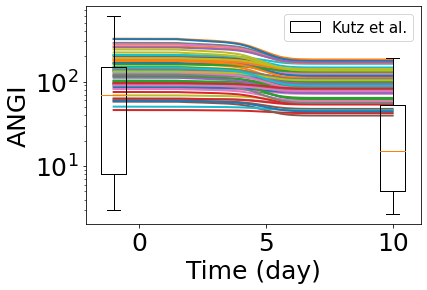

No handles with labels found to put in legend.


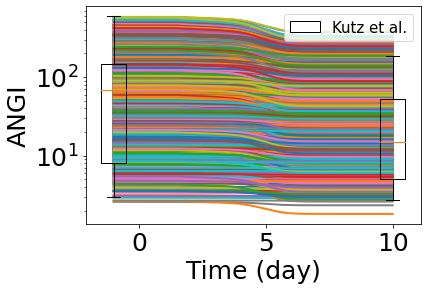

In [8]:
fig2, ax2 = plt.subplots()
for i in range(len(ANGI)):
    Value_ANGI_array = np.array(ANGI[i])
    last_value_ANGI = Value_ANGI_array[-1]
    Value_ANGII_array = np.array(ANGII[i])
    last_value_ANGII = Value_ANGII_array[-1]
    Value_ANG17_array = np.array(ANG17[i])
    last_value_ANG17 = Value_ANG17_array[-1]
    if last_value_ANGII >= 2.1 and last_value_ANGII <= 357 and last_value_ANG17 >= 3 and last_value_ANG17 <= 7.3 and last_value_ANGI >= 2.7 and last_value_ANGI <= 188:
        ax2.plot(tc1 / (24 * 60), np.array(ANGI[i]), linewidth=2)

# experimental data from Kutz
positions=[-1, 10]
boxes = [
    {
        'whislo': 3,    # Bottom whisker position
        'q1'    : 8,    # First quartile (25th percentile)
        'med'   : 69,    # Median         (50th percentile)
        'q3'    : 149,    # Third quartile (75th percentile)
        'whishi': 595,    # Top whisker position
        'fliers': []        # Outliers
    },
    {
        'whislo': 2.7,    # Bottom whisker position
        'q1'    : 5,    # First quartile (25th percentile)
        'med'   : 15,    # Median         (50th percentile)
        'q3'    : 53,    # Third quartile (75th percentile)
        'whishi': 188,    # Top whisker position
        'fliers': []        # Outliers
    },

]
ax2.bxp(boxes, positions, manage_ticks = False, widths=1)

plt.legend()
old_handles, labels = ax2.get_legend_handles_labels()
legend_elements = [Patch(facecolor='white', edgecolor='k', label='Kutz et al.')]

plt.legend(handles=old_handles + legend_elements, loc='upper right', fontsize="15")

plt.xlabel('Time (day)')
plt.ylabel('ANGI')
plt.yscale("log")
#plt.savefig("ANGI_values_kutz.png", dpi=300, bbox_inches='tight')
plt.show()

# ANGI full list
fig21, ax21 = plt.subplots()
for i in range(len(ANGI)):
    ax21.plot(tc1 / (24 * 60), np.array(ANGI[i]), linewidth=2)

ax21.bxp(boxes, positions, manage_ticks = False, widths=1)

plt.legend()
old_handles, labels = ax21.get_legend_handles_labels()
legend_elements = [Patch(facecolor='white', edgecolor='k', label='Kutz et al.')]

plt.legend(handles=old_handles + legend_elements, loc='upper right', fontsize="15")

plt.xlabel('Time (day)')
plt.ylabel('ANGI')
plt.yscale("log")
#plt.savefig("ANGI_values_kutz_full.png", dpi=300, bbox_inches='tight')
plt.show()

### Genetrating plot for ANGII

No handles with labels found to put in legend.


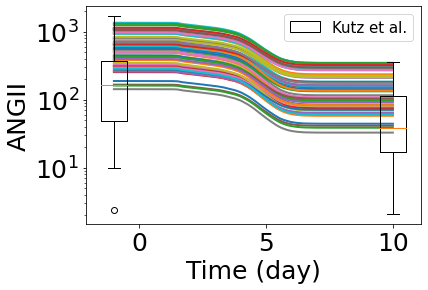

No handles with labels found to put in legend.


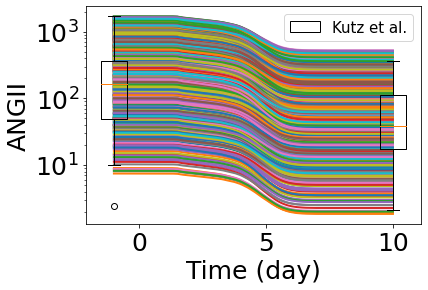

In [9]:
fig, ax = plt.subplots()
for i in range(len(ANGII)):
    Value_ANGI_array = np.array(ANGI[i])
    last_value_ANGI = Value_ANGI_array[-1]
    Value_ANGII_array = np.array(ANGII[i])
    last_value_ANGII = Value_ANGII_array[-1]
    Value_ANG17_array = np.array(ANG17[i])
    last_value_ANG17 = Value_ANG17_array[-1]
    if last_value_ANGII >= 2.1 and last_value_ANGII <= 357 and last_value_ANG17 >= 3 and last_value_ANG17 <= 7.3 and last_value_ANGI >= 2.7 and last_value_ANGI <= 188:
        ax.plot(tc1 / (24 * 60), np.array(ANGII[i]), linewidth=2)
        RAS_initial_value_list.extend([[Value_ANGI_array[0], Value_ANGII_array[0], Value_ANG17_array[0]]])

#print(RAS_initial_value_list)
#print(len(RAS_initial_value_list))
# experimental data from Kutz
positions=[-1, 10]
boxes = [
    {
        'whislo': 10,    # Bottom whisker position
        'q1'    : 49,    # First quartile (25th percentile)
        'med'   : 166,    # Median         (50th percentile)
        'q3'    : 367,    # Third quartile (75th percentile)
        'whishi': 1687,    # Top whisker position
        'fliers': [2.4]        # Outliers
    },
    {
        'whislo': 2.1,    # Bottom whisker position
        'q1'    : 17.3,    # First quartile (25th percentile)
        'med'   : 38,    # Median         (50th percentile)
        'q3'    : 114,    # Third quartile (75th percentile)
        'whishi': 357,    # Top whisker position
        'fliers': []        # Outliers
    },

]
ax.bxp(boxes, positions, manage_ticks = False, widths=1)

plt.legend()
old_handles, labels = ax.get_legend_handles_labels()
legend_elements = [Patch(facecolor='white', edgecolor='k', label='Kutz et al.')]

plt.legend(handles=old_handles + legend_elements, loc='upper right', fontsize="15")

plt.xlabel('Time (day)')
plt.ylabel('ANGII')
plt.yscale("log")
#plt.savefig("ANGII_values_kutz.png", dpi=300, bbox_inches='tight')
plt.show()

# ANGII full list
fig0, ax0 = plt.subplots()
for i in range(len(ANGII)):
    ax0.plot(tc1 / (24 * 60), np.array(ANGII[i]), linewidth=2)

ax0.bxp(boxes, positions, manage_ticks = False, widths=1)

plt.legend()
old_handles, labels = ax0.get_legend_handles_labels()
legend_elements = [Patch(facecolor='white', edgecolor='k', label='Kutz et al.')]

plt.legend(handles=old_handles + legend_elements, loc='upper right', fontsize="15")

plt.xlabel('Time (day)')
plt.ylabel('ANGII')
plt.yscale("log")
#plt.savefig("ANGII_values_kutz_full.png", dpi=300, bbox_inches='tight')
plt.show()

### Genetrating plot for ANG1-7

No handles with labels found to put in legend.


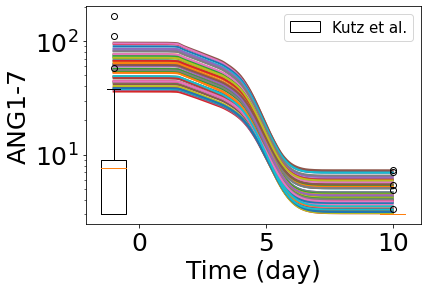

No handles with labels found to put in legend.


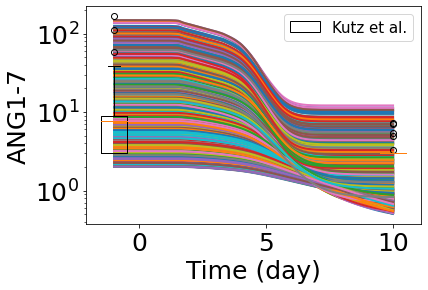

In [10]:
fig1, ax1 = plt.subplots()
for i in range(len(ANG17)):
    Value_ANGI_array = np.array(ANGI[i])
    last_value_ANGI = Value_ANGI_array[-1]
    Value_ANGII_array = np.array(ANGII[i])
    last_value_ANGII = Value_ANGII_array[-1]
    Value_ANG17_array = np.array(ANG17[i])
    last_value_ANG17 = Value_ANG17_array[-1]
    if last_value_ANGII >= 2.1 and last_value_ANGII <= 357 and last_value_ANG17 >= 3 and last_value_ANG17 <= 7.3 and last_value_ANGI >= 2.7 and last_value_ANGI <= 188:
        ax1.plot(tc1 / (24 * 60), np.array(ANG17[i]), linewidth=2)

# experimental data from Kutz
positions=[-1, 10]
boxes = [
    {
        'whislo': 3,    # Bottom whisker position
        'q1'    : 3,    # First quartile (25th percentile)
        'med'   : 7.6,    # Median         (50th percentile)
        'q3'    : 9,    # Third quartile (75th percentile)
        'whishi': 38.1,    # Top whisker position
        'fliers': [58, 111, 166]        # Outliers
    },
    {
        'whislo': 3,    # Bottom whisker position
        'q1'    : 3,    # First quartile (25th percentile)
        'med'   : 3,    # Median         (50th percentile)
        'q3'    : 3,    # Third quartile (75th percentile)
        'whishi': 3,    # Top whisker position
        'fliers': [3.3, 4.9, 5.4, 7, 7.3]        # Outliers
    },

]
ax1.bxp(boxes, positions, manage_ticks = False, widths=1)

plt.legend()
old_handles, labels = ax1.get_legend_handles_labels()
legend_elements = [Patch(facecolor='white', edgecolor='k', label='Kutz et al.')]

plt.legend(handles=old_handles + legend_elements, loc='upper right', fontsize="15")

plt.xlabel('Time (day)')
plt.ylabel('ANG1-7')
plt.yscale("log")
#plt.savefig("ANG1-7_values_kutz.png", dpi = 300, bbox_inches='tight')
plt.show()


# ANG(1-7) full list
fig11, ax11 = plt.subplots()
for i in range(len(ANG17)):
    ax11.plot(tc1 / (24 * 60), np.array(ANG17[i]), linewidth=2)

ax11.bxp(boxes, positions, manage_ticks = False, widths=1)

plt.legend()
old_handles, labels = ax11.get_legend_handles_labels()
legend_elements = [Patch(facecolor='white', edgecolor='k', label='Kutz et al.')]

plt.legend(handles=old_handles + legend_elements, loc='upper right', fontsize="15")

plt.xlabel('Time (day)')
plt.ylabel('ANG1-7')
plt.yscale("log")
#plt.savefig("ANG1-7_values_kutz_full.png", dpi = 300, bbox_inches='tight')
plt.show()

### Genetrating plot for unconverted ANGII

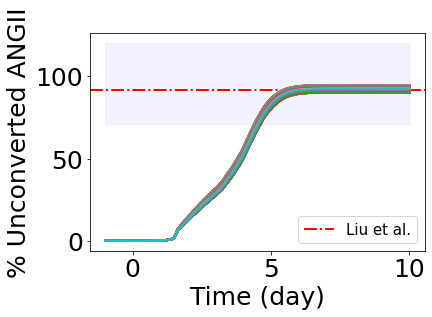

In [11]:
fig3, ax3 = plt.subplots()
normal_mean = (25+129)/2
upper_th = ((169.5-normal_mean)/normal_mean)*100
lower_th = ((131.5-normal_mean)/normal_mean)*100
mean_range = ((147.4-normal_mean)/normal_mean)*100

# Fill in area under the curve and the horizontal lines
ax3.fill_between(x=tc1 / (24 * 60), y1=upper_th, y2=lower_th, color='blue',  interpolate=True, alpha=.05)

# Horizontal lines
ax3.axhline(mean_range, linestyle='-.', color='red', label='Liu et al.', linewidth=2)

for i in range(len(ANGIIin)):
    ax3.plot(tc1 / (24 * 60), np.array(ANGIIin[i]), linewidth=2)
plt.legend(loc='lower right', prop={"size":15})
plt.xlabel('Time (day)')
plt.ylabel('% Unconverted ANGII')
#plt.savefig("ANGII_change_Liu.png", dpi = 300, bbox_inches='tight')
plt.show()

### List of initial values [ANGI, ANGII, ANG1-7] satisfying both intput and output conditions

In [12]:
print(len(RAS_initial_value_list))
print(RAS_initial_value_list)

60
[[99.27001913098346, 188.52485590824227, 62.622646348264745], [204.42452587052622, 490.49381415122866, 49.12088412177595], [89.23593436648049, 318.4854952609752, 73.99871529271248], [139.87514218133643, 254.8111518664238, 94.31248970507094], [120.39960521103485, 804.7157449995767, 55.009018127685664], [116.42614374388026, 314.77494842174076, 46.95576431253973], [190.35946656388427, 496.34851686500485, 52.980606997410334], [287.6705596753747, 560.0251982731011, 83.3236228865631], [150.35511963717414, 448.3268982413878, 60.43687981635065], [207.82431361915127, 785.9659312178417, 68.12784720721316], [132.49807761077196, 556.777479698141, 55.02926935621953], [165.4127584431791, 265.4159313680772, 76.9452001671767], [101.4787844217554, 1243.569595669849, 43.02011815077304], [45.979818278651436, 1051.7422773930932, 35.99484547433755], [182.20795934786682, 425.1366809599467, 76.15735631963392], [199.15851941402684, 638.4309915978394, 97.15061722820064], [82.81962456796143, 980.715486849390